In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.mlab as mlab
from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 


# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }


plt.rcParams.update(params)
plt.rc('text', usetex=True)

"""
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
"""
# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [2]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "mean_energy": [], "standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["mean_energy"].append(mean_energy_alpha)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe

## Non-interacting system (one particle)

In [4]:
N = 500       # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,  # METROPOLIS
                         #dt=1e-10,     # METROPOLIS-HASTINGS
                         nchains=1,
                         warm=True,
                         warmup_iter=5000,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=False,
                         max_iter=70000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-6,
                         )

end = time.time()
print("Sampler elapsed time:", end - start)


Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 23.912841081619263


### Histogram approach

In [5]:
distance_samples_NIN10 = sampler.distance_samples.flatten()

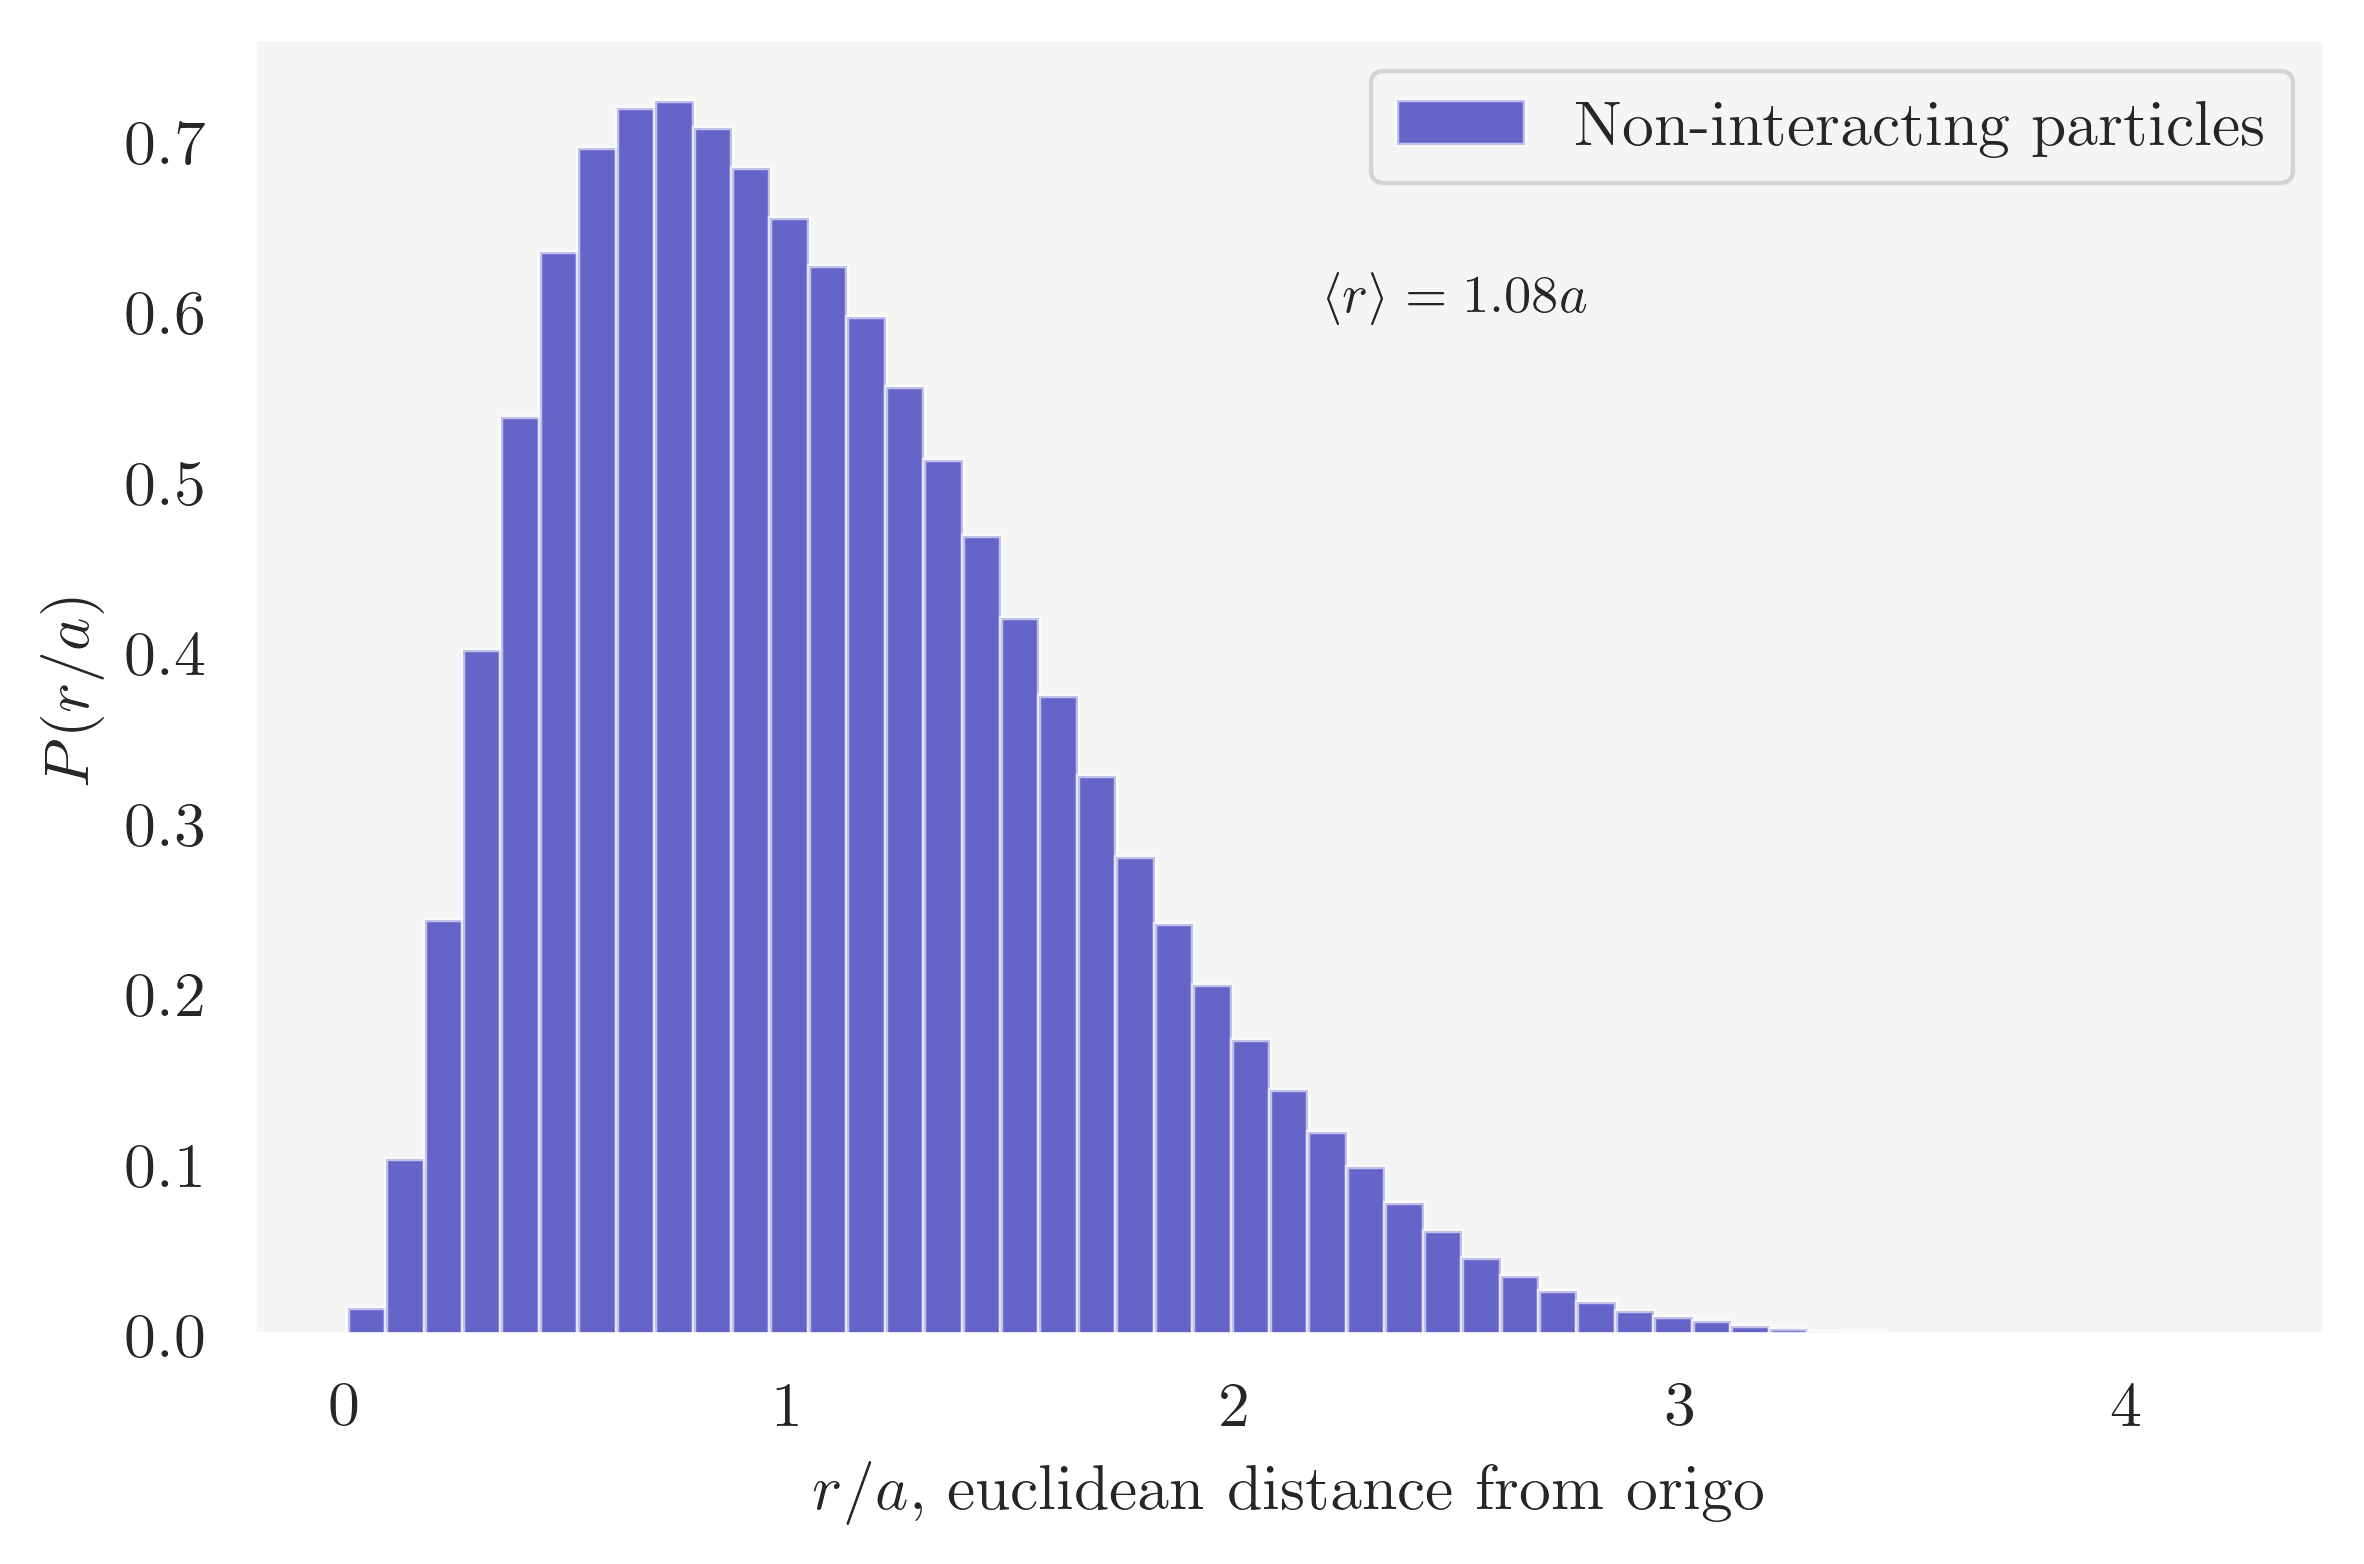

In [6]:
#distance_samples = sampler.distance_samples
# best fit
(mu, sigma) = norm.fit(distance_samples_NIN10)
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distance_samples_NIN10, bins=np.linspace(np.min(distance_samples_NIN10), np.max(distance_samples_NIN10), 50), density=True, color='#0504aa',
                            alpha=0.6, label="Non-interacting particles")
plt.grid(True, alpha=0.75)
plt.xlabel(r'$r/a$, euclidean distance from origo')
plt.ylabel(r'$P(r/a)$')
plt.text(2.2, 0.6, r'$\langle r\rangle={distance_mean:.2f} a$'.format(distance_mean=np.mean(distance_samples_NIN10)))
maxfreq = n.max()
"""
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2, label="Fitted line")
"""
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) + 1 if maxfreq % 10 else maxfreq + 1)
plt.legend()

fig.savefig(fig_path("NI_OBD_1.pdf"), bbox_inches='tight')

## Interacting system (10 particles) 

In [11]:
N = 10        # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,  # METROPOLIS
                         #dt=1e-10,     # METROPOLIS-HASTINGS
                         nchains=1,
                         warm=True,
                         warmup_iter=5000,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=False,
                         max_iter=70000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-6,
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 104.4046938419342


In [12]:
distance_samples_N10 = sampler.distance_samples.flatten()

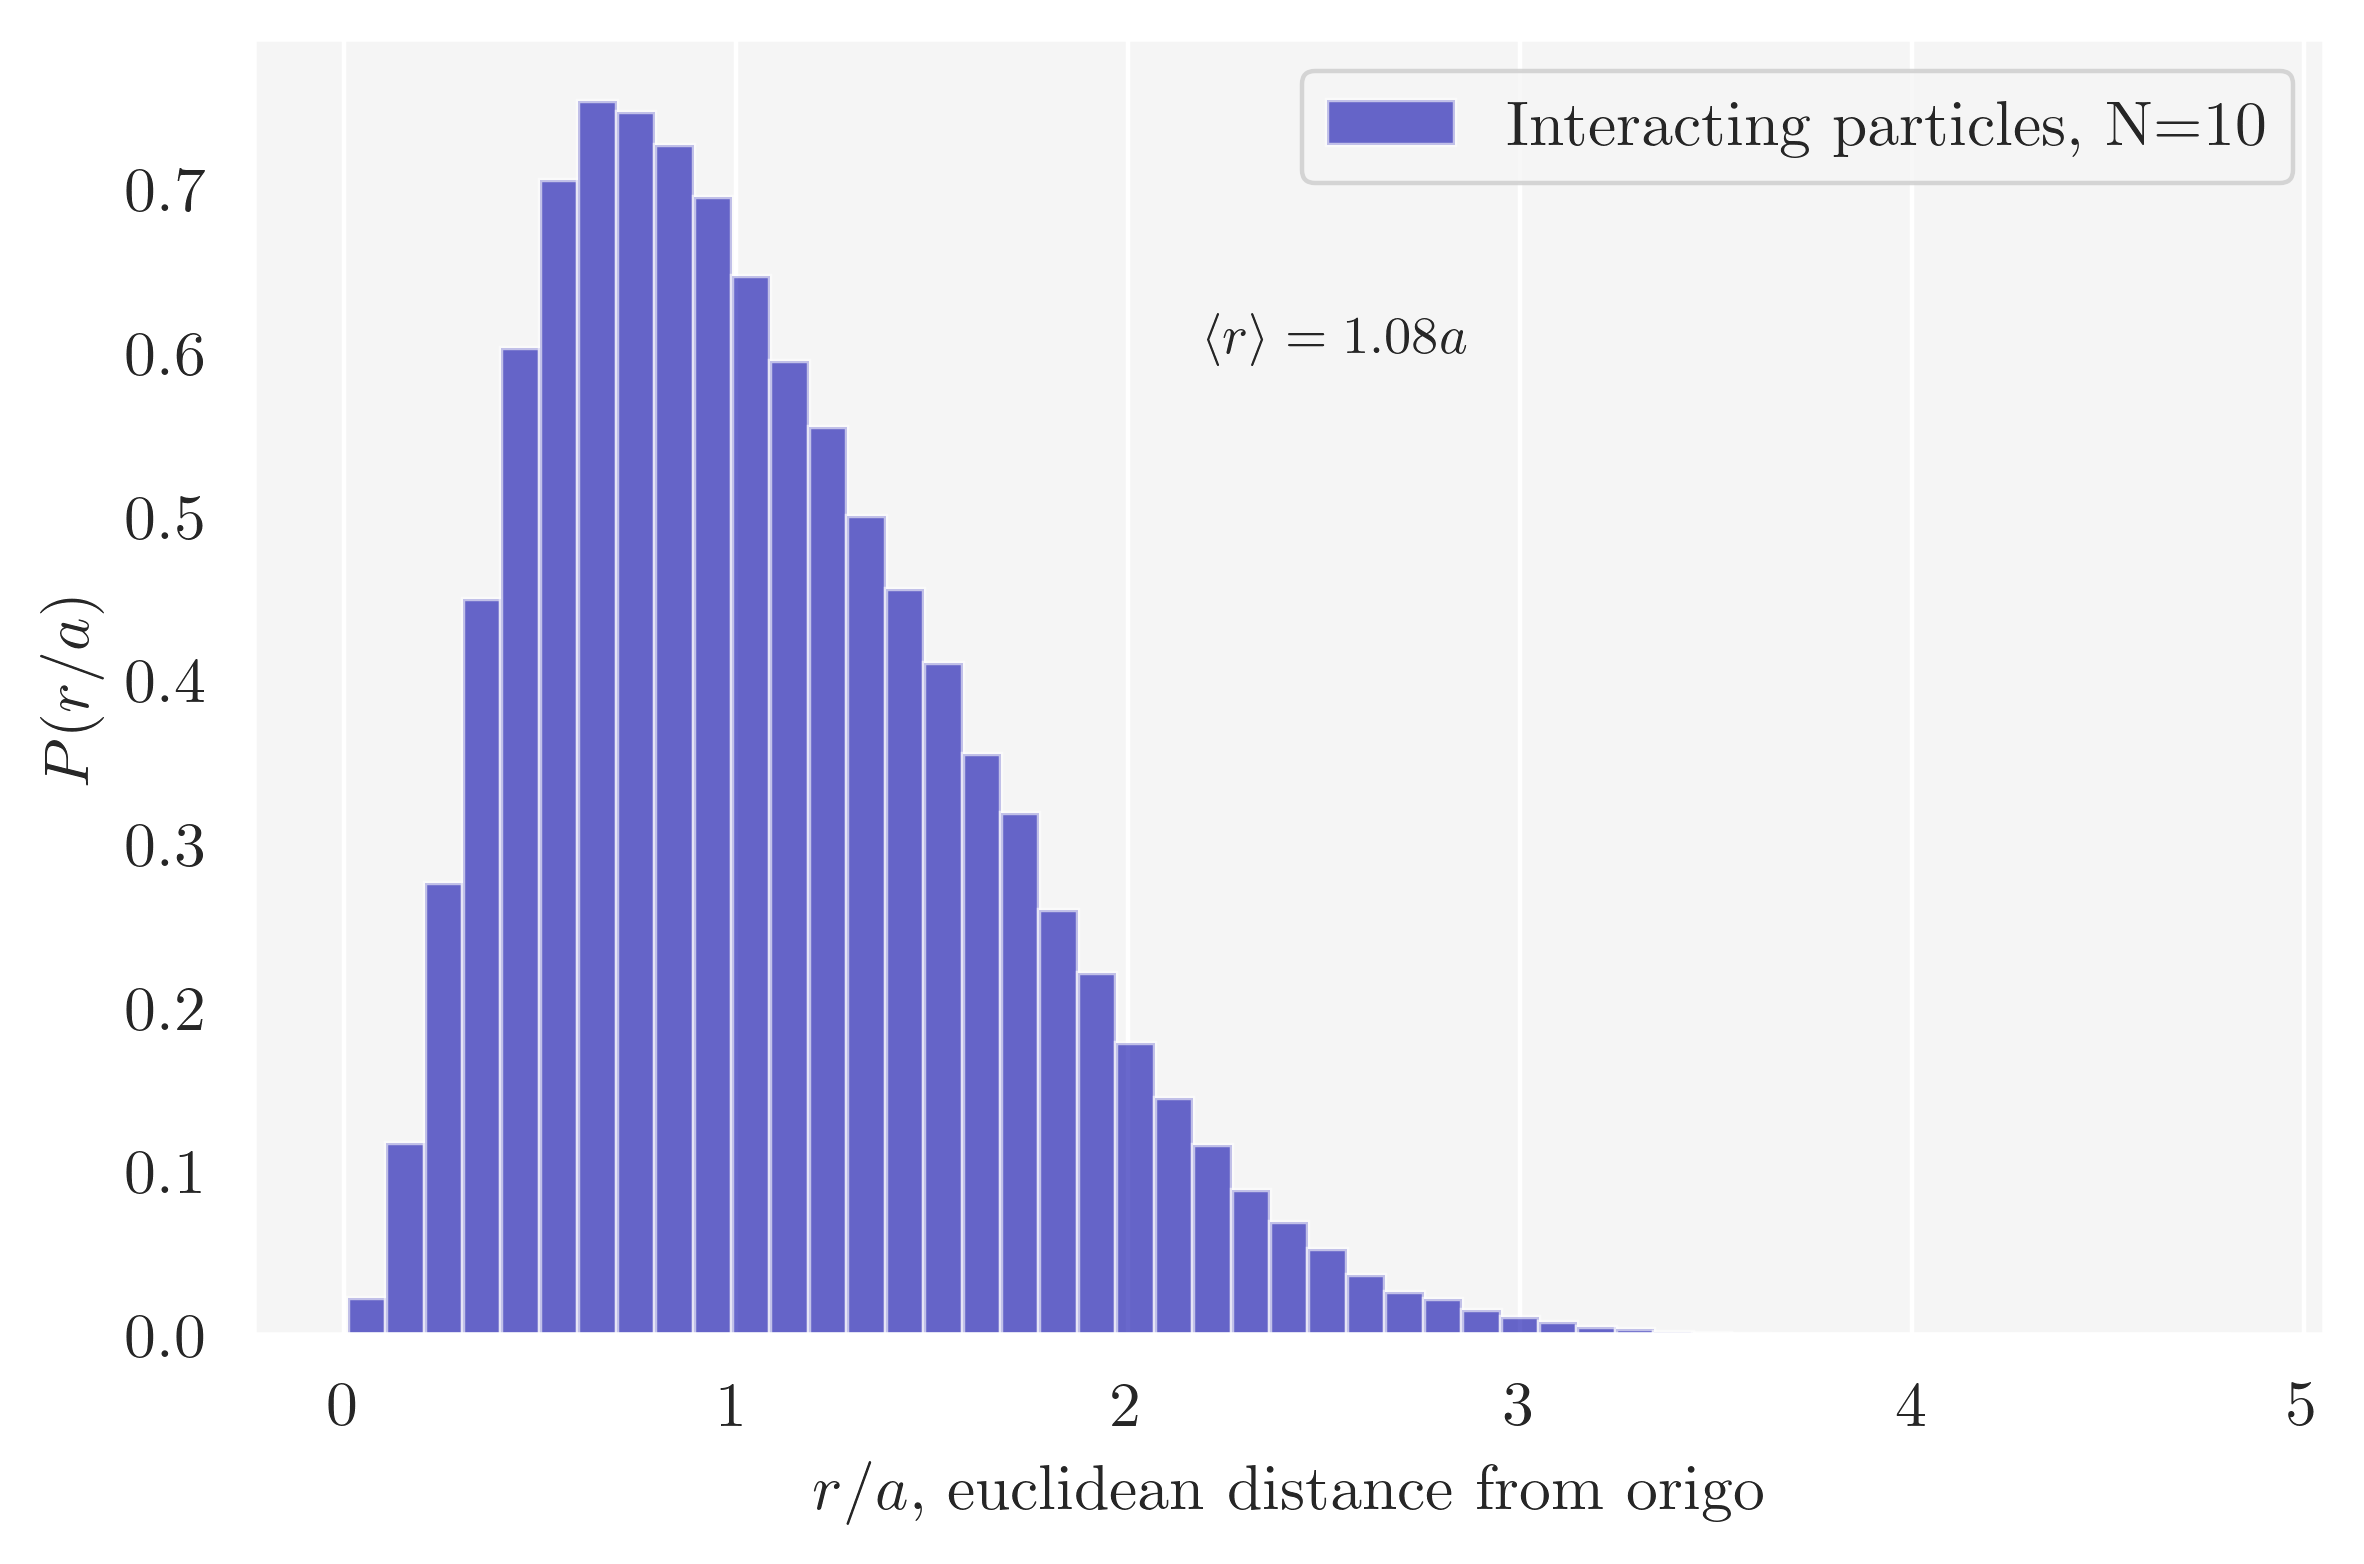

In [13]:
#distance_samples_N10[np.lexsort(np.fliplr(distance_samples_N10).T)]
#distance_samples_N10 = np.mean(distance_samples_N10, axis=1)
# best fit
(mu, sigma) = norm.fit(distance_samples_N10)
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distance_samples_N10, bins=np.linspace(np.min(distance_samples_N10), np.max(distance_samples_N10), 50), density=True, color='#0504aa',
                            alpha=0.6, label="Interacting particles, N=10")
plt.grid(axis='y', alpha=0.75)
plt.xlabel(r'$r/a$, euclidean distance from origo')
plt.ylabel(r'$P(r/a)$')
plt.text(2.2, 0.6, r'$\langle r\rangle={distance_mean:.2f} a$'.format(distance_mean=np.mean(distance_samples_N10)))
maxfreq = n.max()
"""
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2, label="Fitted line")
"""
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) + 1 if maxfreq % 10 else maxfreq + 1)
plt.legend()

fig.savefig(fig_path("I_OBD_N10.pdf"), bbox_inches='tight')

## 50 interacting particles

In [14]:
N = 50        # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,  # METROPOLIS
                         #dt=1e-10,     # METROPOLIS-HASTINGS
                         nchains=1,
                         warm=True,
                         warmup_iter=5000,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=False,
                         max_iter=70000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-6,
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 204.83583545684814


In [22]:
distance_samples_N50 = sampler.distance_samples.flatten()
print(distance_samples_N50)

[0.00483048 0.00350236 0.00436494 ... 0.02203721 0.02171538 0.02198403]


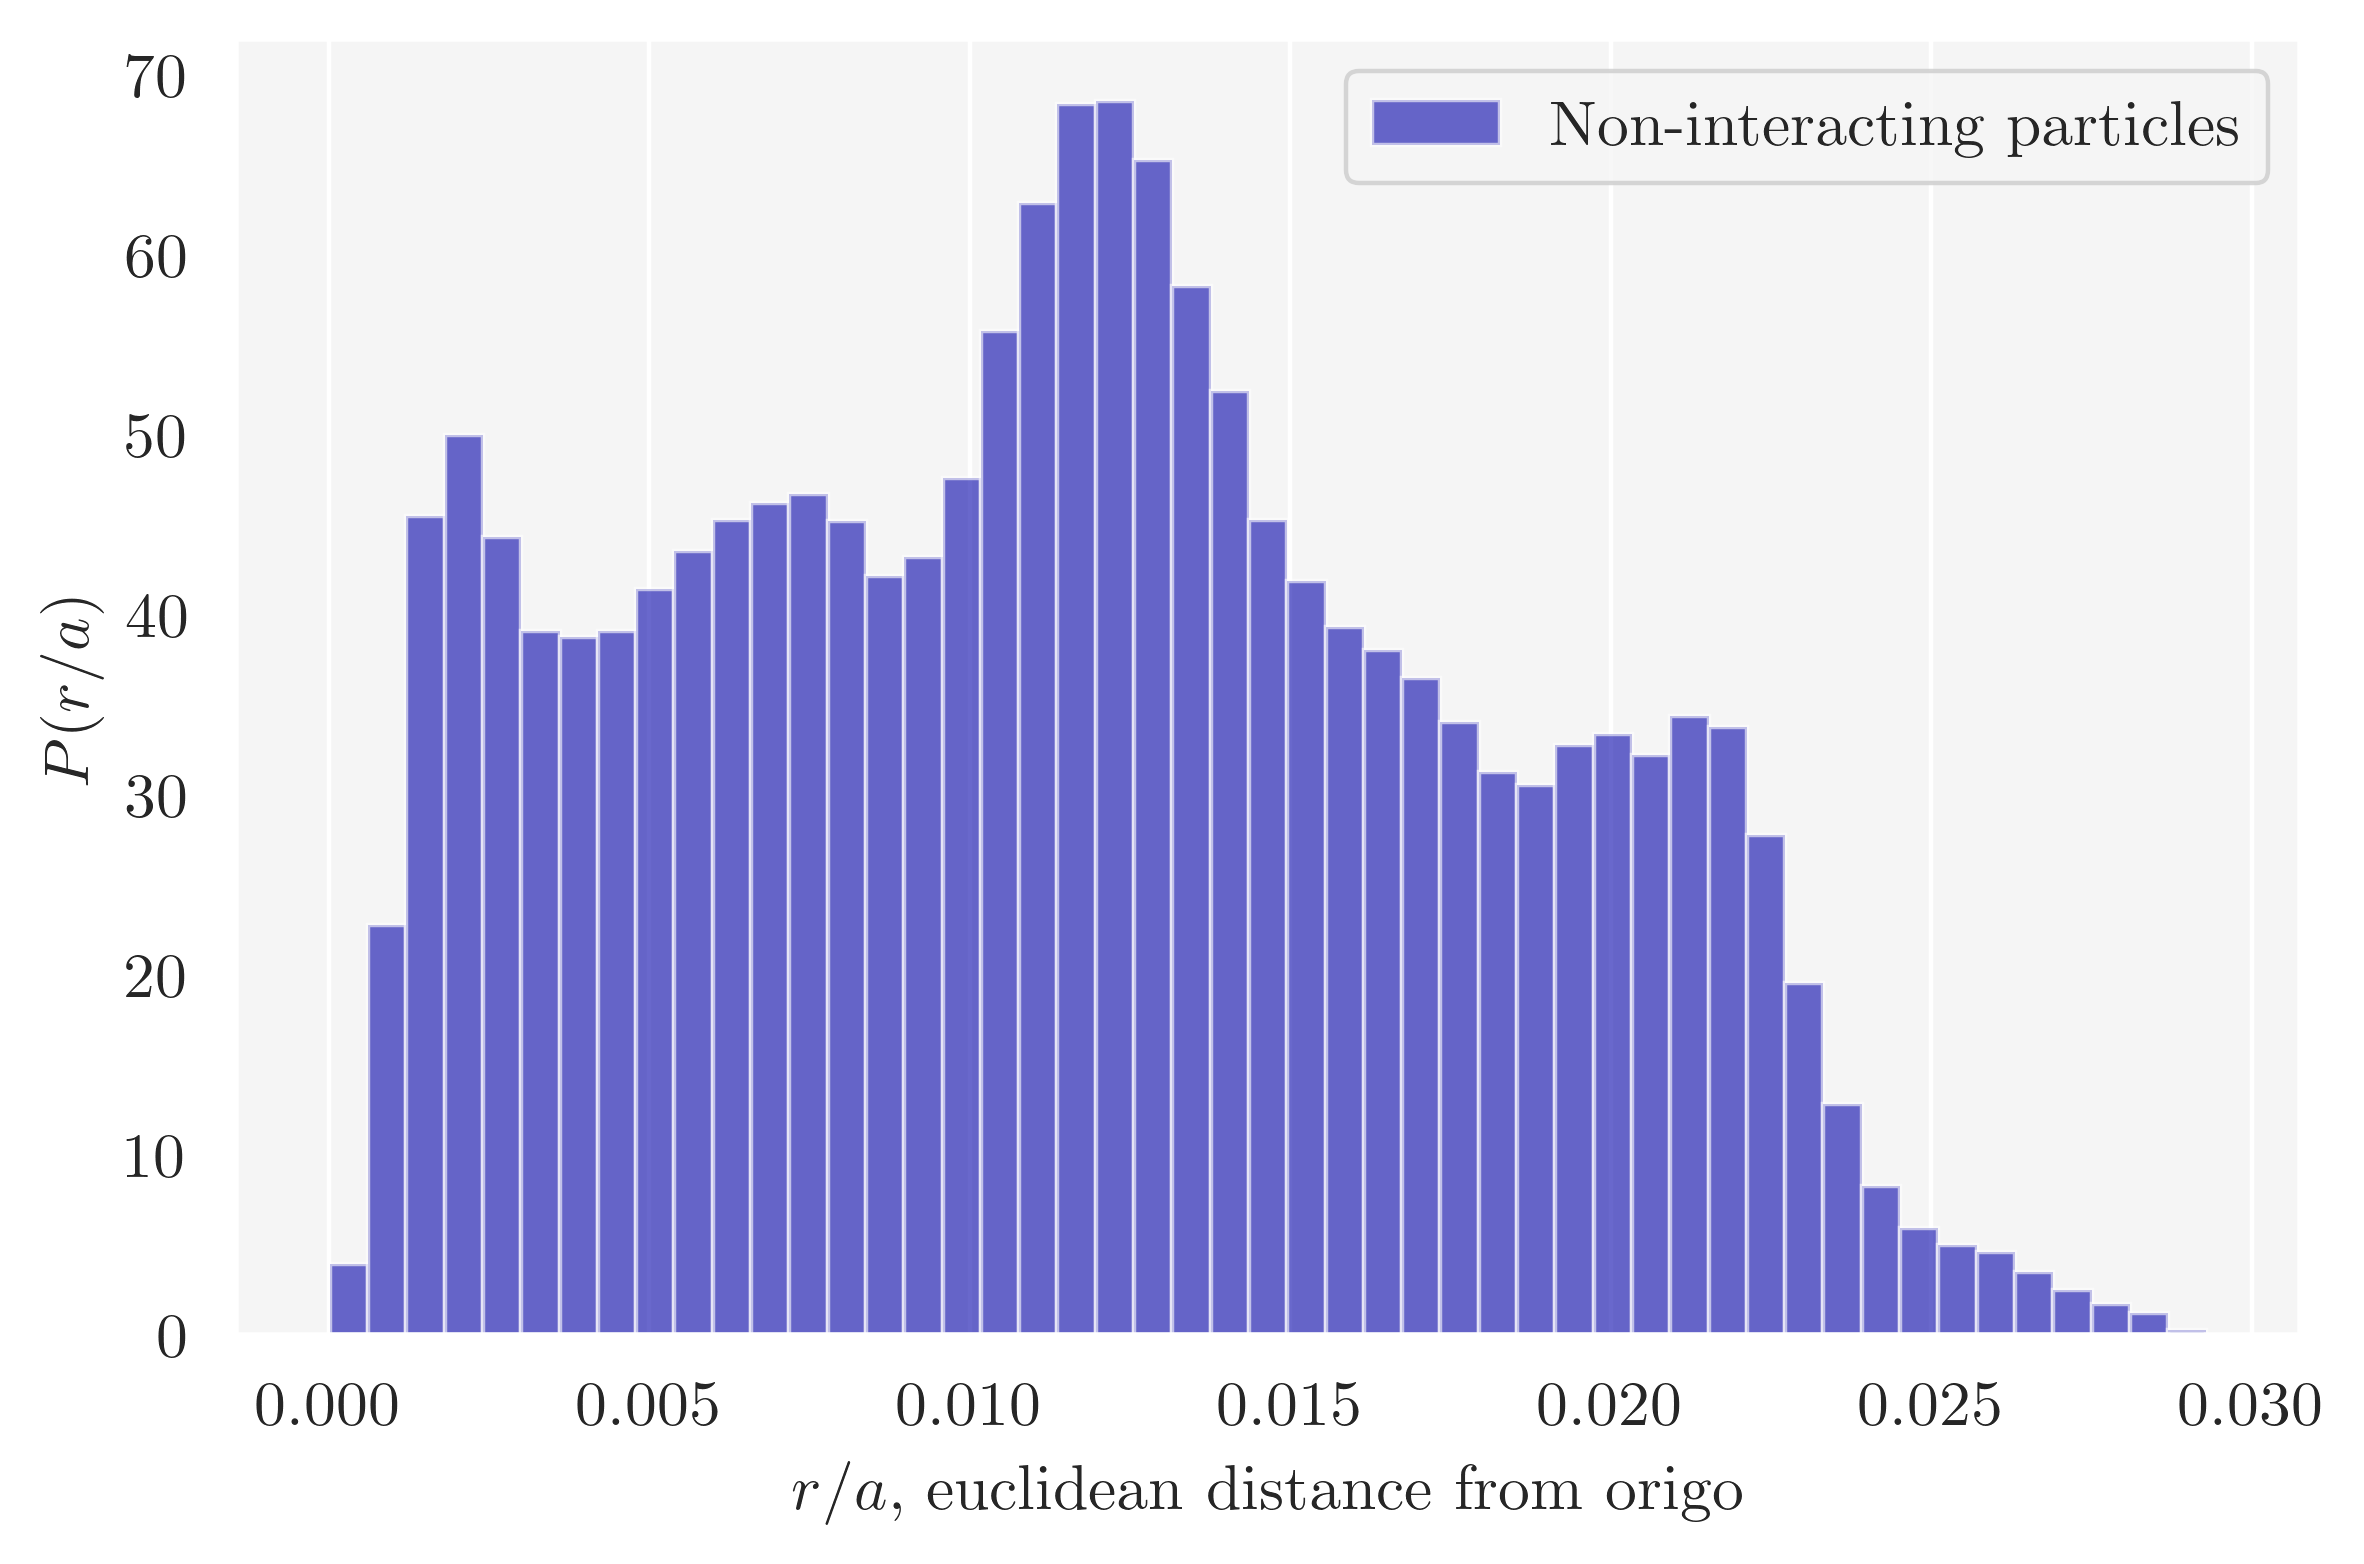

In [23]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distance_samples_N50, bins=np.linspace(np.min(distance_samples_N50), np.max(distance_samples_N50), 50), density=True, color='#0504aa',
                            alpha=0.6, label="Non-interacting particles")
plt.grid(axis='y', alpha=0.75)
plt.xlabel(r'$r/a$, euclidean distance from origo')
plt.ylabel(r'$P(r/a)$')
#plt.text(2.2, 0.6, r'$\langle r\rangle={distance_mean:.2f} a$'.format(distance_mean=np.mean(distance_samples_N50)))
plt.legend()

fig.savefig(fig_path("I_OBD_N50.pdf"), bbox_inches='tight')

### 100 interacting particles

In [ ]:
N = 100        # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,  # METROPOLIS
                         #dt=1e-10,     # METROPOLIS-HASTINGS
                         nchains=1,
                         warm=True,
                         warmup_iter=5000,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=False,
                         max_iter=70000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-6,
                         )

end = time.time()
print("Sampler elapsed time:", end - start)

In [ ]:
distance_samples_N100 = sampler.distance_samples.flatten()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distance_samples_N100, bins=np.linspace(np.min(distance_samples_N100), np.max(distance_samples_N100), 50), density=True, color='#0504aa',
                            alpha=0.6, label="Non-interacting particles")
plt.grid(axis='y', alpha=0.75)
plt.xlabel(r'$r/a$, euclidean distance from origo')
plt.ylabel(r'$P(r/a)$')
plt.text(2.2, 0.6, r'$\langle r\rangle={distance_mean:.2f} a$'.format(distance_mean=np.mean(distance_samples_N100)))
plt.legend()

fig.savefig(fig_path("I_OBD_N100.pdf"), bbox_inches='tight')